<a href="https://colab.research.google.com/github/ssnirgudkar/Home-AIML/blob/main/IRsegmentationauto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade segments-ai


In [ ]:
from segments import SegmentsClient
api_key = "a89182567b17766b91773021b18d04574cd75109"
client = SegmentsClient(api_key)

In [4]:
dataset_identifier = "ssnirgudkar/PilotIR"


In [ ]:
#commenting this for now, since this will just give all the data sets available in my login
#dataset = client.get_dataset(dataset_identifier)
#print(dataset)


In [ ]:
from segments import SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
release_file = client.get_release(dataset_identifier,'V2.0')
#print(release_file)
releasedataset = SegmentsDataset(release_file, labelset='segmentation', filter_by='labeled')


In [ ]:
#install dependencies for detectron 2
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
!gcc --version



In [ ]:
#install detectron2 (Colab has CUDA 10.1 + torch 1.8)
import torch 
assert torch.__version__.startswith("1.8") #need to manually install 1.8 only if colab changes it's default version. as we see above, the default is 1.8 rt now
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime



In [ ]:
#setup logger for detectron2 
import detectron2 
from detectron2.utils.logger import setup_logger 
setup_logger()

In [ ]:

#clone segments.ai repo for their utils code 
!git clone https://github.com/segments-ai/fast-labeling-workflow/
%cd fast-labeling-workflow
print (os.getcwd())

In [ ]:
from segments import SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
release_file = client.get_release(dataset_identifier,'V2.0')
#print(release_file)
releasedataset = SegmentsDataset(release_file, labelset='segmentation', filter_by='labeled')
from utils import train_model
model = train_model(releasedataset)

In [ ]:
#should save the model somewhere so it doesn't have to be recreated eachtime. this did not work
#model.save('/content/drive/MyDrive/Models/detectronwithir')


In [36]:
dataset_identifier_infer = "ssnirgudkar/IRGray-100-set2-3classes"
dataset_infer = client.get_dataset(dataset_identifier_infer)


In [ ]:
infer_release_file = client.get_release(dataset_identifier_infer,'Fortestingraw1')
infer_releasedataset = SegmentsDataset(infer_release_file, labelset='ground-truth', filter_by='unlabeled')

/content/fast-labeling-workflow/fast-labeling-workflow/fast-labeling-workflow
segmentation bitmap executed


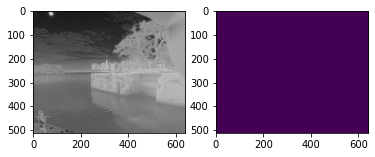

[]
/content/fast-labeling-workflow/fast-labeling-workflow/fast-labeling-workflow
segmentation bitmap executed


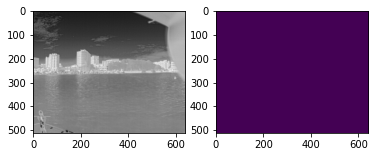

[]
/content/fast-labeling-workflow/fast-labeling-workflow/fast-labeling-workflow
segmentation bitmap executed


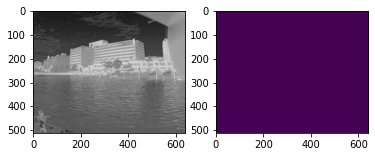

[]
/content/fast-labeling-workflow/fast-labeling-workflow/fast-labeling-workflow
segmentation bitmap executed


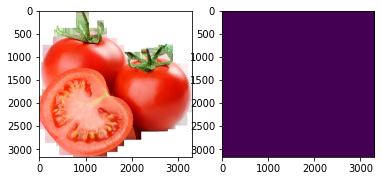

[]


In [48]:
from segments import SegmentsDataset
from segments.utils import export_dataset
from segments.utils import bitmap2file

import cv2 
import numpy as np 
import os 
from utils import visualize 
#this needs 3 channel image. so had to convert grayscale IR to RGB - 3 channels by copying the same pixel value on all 3
for sample in infer_releasedataset:
   infer_image = sample['image'] 
      
   #imgcv = cv2.imread(infer_image)
   #assert not isinstance(imgcv,type(None)), 'image not found'
   #print ("file read = {0}".format(imgcv))
   print(os.getcwd())  # prints current working directory
   #infer_image2 = RemoveAlphaChannel[infer_image, White]
   infer_image2 = infer_image.convert("RGB")
   segmentation_bitmap, annotations = model(infer_image2)
   print("segmentation bitmap executed")
   #visualize the predictions 
   visualize(infer_image2, segmentation_bitmap)
   print(annotations)

# Upload the predictions to Segments.ai
   file = bitmap2file(segmentation_bitmap)
   asset = client.upload_asset(file, 'label.png')    
   attributes = {
        'format_version': '0.1',
        'annotations': annotations,
        'segmentation_bitmap': { 'url': asset['url'] },
   }
   client.add_label(sample['uuid'], 'ground-truth', attributes, label_status='PRELABELED')
   
  

In [ ]:
import cv2 
image1 = '/content/drive/MyDrive/Models/MVI_1463_NIR_RF_1_Ins.png' #singapore ir png
image2 = '/content/drive/MyDrive/Models/1603391862.128166_color.png' #personal 2nd set ir color 3 channels png
image3 = '/content/drive/MyDrive/Models/MVI_0797_VIS_OB.png' #singapore rgb
image4 = '/content/drive/MyDrive/Models/1602782428.150594.png' #personal 1st set 

img1 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
assert not isinstance(img1,type(None)), 'image not found'
#print ("file read = {0}".format(img1))
print (img1.shape)
print(img1[1,:])
#height,width, channel = img1.shape
